In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Scalar

In [2]:
class Scalar:
    def __init__(self, value, op=None, children=()):
        self.value = value
        self.grad = 0
        self.is_leaf = not children
        self.children = children
        self.op = op
        self._backward = lambda : None

    def __add__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.value + other.value, children=(self, other), op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
        
    def __sub__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.value - other.value, op='-',  children=(self, other))
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad
        out._backward = _backward
        return out
        


    def __mul__(self, other):
        other = other if isinstance(other, Scalar) else Scalar(other)
        out = Scalar(self.value * other.value, op='*',  children=(self, other))
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return other * self
    
    def __truediv__(self, other):
        return self * (other ** -1)
            
    def __pow__(self, other):
        out = Scalar(self.value ** other, children=(self, ), op='power')

        def _backward():
            self.grad += other * self.value ** (other - 1) * out.grad
        
        out._backward = _backward
        return out
    

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()
        # self.grad = 1
        # self._backward()
        # child_list  = [c for c in self.children]
        # while child_list:
        #     curr = child_list.pop(0)
        #     curr._backward()
        #     if not curr.is_leaf:
        #         for d in curr.children:
        #             child_list.append(d)

    def exp(self):
        x = self.value
        out = Scalar(np.exp(x), children=(self, ), op='exp')
        
        def _backward():
            self.grad += out.grad * out.value
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.value
        fun = lambda x: (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
        out = Scalar(fun(x), children=(self, ))

        def _backward():
            self.grad += out.grad * (1 - fun(x)**2)
        out._backward = _backward
        return out
    
    def sigmoid(self):
        x = self.value
        fun = lambda x: 1/(1 + np.exp(-x))
        out = Scalar(fun(x), children=(self, ))

        def _backward():
            self.grad += out.grad * fun(x) * (1-fun(x))
        out._backward = _backward
        return out
    
    def relu(self):
        x = self.value
        out = Scalar(np.max([0, x]), children=(self,))

        def _backward():
            self.grad += 1 if x > 0 else 0
        out._backward = _backward
        return out
    
    def leaky_relu(self, alpha=0.1):
        x = self.value
        out = Scalar(np.max([x, -alpha*x]), children=(self, ))

        def _backward():
            self.grad += 1 if x > 0 else alpha
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Scalar(data: {self.value})"

In [390]:
a = Scalar(2.1)
b = Scalar(0.8)
c = a * b
d = c * 0.25
e = d.tanh()


In [391]:
e.backward()

In [394]:
a,b,c,d,e

(Scalar(data: 2.1),
 Scalar(data: 0.8),
 Scalar(data: 1.6800000000000002),
 Scalar(data: 0.42000000000000004),
 Scalar(data: 0.39693043200507755))

## Neural Network

In [157]:
class Neuron:
    def __init__(self, nin):
        self.w = [Scalar(x) for x in np.random.normal(size=nin)]
        self.b = Scalar(0.0)

    
    def __call__(self, input, activation='relu', args=None):
        assert len(input) == len(self.w), "input size is not equal to weights initialisation"
        out = sum((wi * xi for wi, xi in zip(self.w, input)), self.b)
        if activation == 'relu':
            post_act = out.relu()
        elif activation == 'leaky_relu':
            alpha = 0.1 if args is None else args 
            post_act = out.leaky_relu(alpha=alpha)
        elif activation == 'sigmoid':
            post_act = out.sigmoid()
        elif activation == 'tanh':
            post_act = out.tanh()
        else: 
            raise ValueError("Incorrect Activation Function provided")
        
        return post_act
    
    def parameters(self):
        return self.w + [self.b]
    
    def parameters_count(self):
        return len(self.w) + 1
    

class Layer:
    def __init__(self, lsize, nin):
        self.neurons = [Neuron(nin) for _ in range(lsize)]

    def __call__(self, *args, activation='relu'):
        layer_out = [neuron(args[0], activation=activation) for neuron in self.neurons]
        return layer_out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def parameters_count(self):
        return sum(x.parameters_count() for x in self.neurons)

class MLP:
    def __init__(self, lsizes, nin):
        sz = [nin] + lsizes
        self.layers = [Layer(sz[i+1], sz[i]) for i in range(len(lsizes))]

    def __call__(self, *args, activation='relu'):
        x = args[0]
        for layer in self.layers:
            x  = layer(x, activation=activation)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def parameters_count(self):
        return sum(x.parameters_count() for x in self.layers)


In [158]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1, 0.5], 
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1]
]

ys = [1, -1, -1, 1]


In [159]:
model = MLP([4, 4, 1], 3)

In [6]:
loss_t = []
for _ in range(20):
    ypred = [model(x, activation='tanh')[0] for x in xs]
    loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
    for p in model.parameters():
        p.grad = 0.0

    loss.backward()

    for p in model.parameters():
        p.value += -0.05 * p.grad
    
    loss_t.append(loss.value)

In [7]:
ypred

[Scalar(data: 0.8483610396224256),
 Scalar(data: -0.8188368351386829),
 Scalar(data: -0.8274681586473587),
 Scalar(data: 0.8212747397934365)]

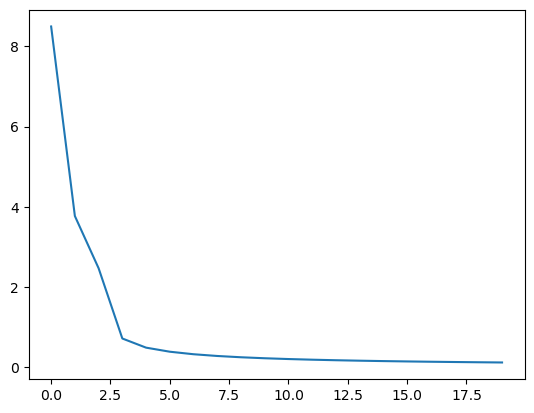

In [8]:

plt.plot(loss_t[:], '-')

## Tensor

#### Matrix Equations Derivations
Let us consider a simple 2-layer perceptron with input $x_1 \in \mathbb{R}^{N_1 \times 1}$ and some non-linear activation functions. We have the following equations, along with their shapes:
$$a_1 = W_1 x_1 + b_1, \hspace{10pt} W_1 \in \mathbb{R}^{M_1 \times N_1}  \hspace{5pt} b_1, a_1 \in \mathbb{R}^{M_1 \times 1} $$
 $$ h_1 = f_1(a_1), \hspace{10pt} h_1 \in \mathbb{R}^{M_1 \times 1} $$
$$a_2 = W_2 h_1 + b_2, \hspace{10pt} W_2 \in \mathbb{R}^{M_2 \times M_1}  \hspace{5pt} b_2, a_2 \in \mathbb{R}^{M_2 \times 1} $$
 $$ y_2 = f_2(a_2), \hspace{10pt} y_2 \in \mathbb{R}^{M_2 \times 1} $$
 $$L = \frac{1}{2}(y_2 - y_g)^2 \hspace{10pt} L \in \mathbb{R}^{M_2 \times 1}$$


 Now, we consider the back-propagation step, starting with the first derivatives:
 $$\frac{\partial L} {\partial y_2} = y_2 - y_g$$
 $$\frac{\partial L} {\partial a_2} = \frac{\partial L} {\partial y_2} \cdot \frac{\partial y_2} {\partial y_2} =  (y_2 - y_g) \odot f_2'(a_2)$$
  $$\boxed{\frac{\partial L} {\partial W_2} = \frac{\partial L} {\partial a_2} \cdot \frac{\partial a_2} {\partial W_2} =   (y_2 - y_g) \odot f_2'(a_2) \times h_1^T}$$
$$\boxed{\frac{\partial L} {\partial b_2} = \frac{\partial L} {\partial a_2} \cdot \frac{\partial a_2} {\partial b_2} =   (y_2 - y_g) \odot f_2'(a_2) \times 1}$$
$$\frac{\partial L} {\partial h_1} = \frac{\partial L} {\partial a_2} \cdot \frac{\partial a_2} {\partial h_1} =  W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right)  $$
$$\frac{\partial L} {\partial a_1} = \frac{\partial L} {\partial h_1} \cdot \frac{\partial h_1} {\partial a_1} =    W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right) \odot f_1'(a_1) $$
$$\boxed{\frac{\partial L} {\partial W_1} = \frac{\partial L} {\partial a_1} \cdot \frac{\partial a_1} {\partial W_1} =    W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right) \odot f_1'(a_1) \times x_1^T} $$
$$\boxed{\frac{\partial L} {\partial b_1} = \frac{\partial L} {\partial a_1} \cdot \frac{\partial a_1} {\partial b_1} =  W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right) \odot f_1'(a_1)}$$


Now, let us do this generically for an n-layer neural network:
$$a_1 = W_1 x_1 + b_1, \hspace{10pt} W_1 \in \mathbb{R}^{M_1 \times N_1}  \hspace{5pt} b_1, a_1 \in \mathbb{R}^{M_1 \times 1} $$
 $$ h_1 = f_1(a_1), \hspace{10pt} h_1 \in \mathbb{R}^{M_1 \times 1} $$
 $$a_j = W_j h_{j-1} + b_j, \hspace{10pt} W_j \in \mathbb{R}^{M_{j} \times M_{j-1}}  \hspace{5pt} b_j, a_j \in \mathbb{R}^{M_j \times 1} $$
 $$ h_j = f_j(a_j), \hspace{10pt} y_j \in \mathbb{R}^{M_j \times 1} $$
$$a_N = W_N h_{N-1} + b_N, \hspace{10pt} W_n \in \mathbb{R}^{M_{N} \times M_{N-1}}  \hspace{5pt} b_N, a_N \in \mathbb{R}^{M_N \times 1} $$
 $$ y_N = f_N(a_N), \hspace{10pt} y_N \in \mathbb{R}^{M_N \times 1} $$
 $$L = (y_N - y_g)^2 \hspace{10pt} L \in \mathbb{R}^{M_N \times 1}$$

 $$\boxed{\frac{\partial L} {\partial W_j} = \frac{\partial L} {\partial a_j} \cdot \frac{\partial a_j} {\partial W_j} =   \left(W_{j-1}^T \times \left(...W_N \times (y_N - y_g) \odot f_N'(a_N)\right)... \odot f_{N-1}'(a_{N-1}) \right) \odot f_j'(a_j) \times h_{j-1}^T} $$
$$\boxed{\frac{\partial L} {\partial b_j} = \frac{\partial L} {\partial a_j} \cdot \frac{\partial a_j} {\partial b_j} =   \left(W_{j-1}^T \times \left(...W_N \times (y_N - y_g) \odot f_N'(a_N)\right)... \odot f_{N-1}'(a_{N-1}) \right) \odot f_j'(a_j)}$$



#### Matrix Equations Derivations (With Batches)
Now, let us consider a simple 2-layer perceptron with input $x_1 \in \mathbb{R}^{B \times N_1 \times 1}$ and some non-linear activation functions. We have the following equations, along with their shapes:
$$a_1 = W_1 x_1 + b_1, \hspace{10pt} W_1 \in \mathbb{R}^{M_1 \times N_1}  \hspace{5pt} b_1, a_1 \in \mathbb{R}^{M_1 \times 1} $$
 $$ h_1 = f_1(a_1), \hspace{10pt} h_1 \in \mathbb{R}^{M_1 \times 1} $$
$$a_2 = W_2 h_1 + b_2, \hspace{10pt} W_2 \in \mathbb{R}^{M_2 \times M_1}  \hspace{5pt} b_2, a_2 \in \mathbb{R}^{M_2 \times 1} $$
 $$ y_2 = f_2(a_2), \hspace{10pt} y_2 \in \mathbb{R}^{M_2 \times 1} $$
 $$L = \frac{1}{2}(y_2 - y_g)^2 \hspace{10pt} L \in \mathbb{R}^{M_2 \times 1}$$


 Now, we consider the back-propagation step, starting with the first derivatives:
 $$\frac{\partial L} {\partial y_2} = y_2 - y_g$$
 $$\frac{\partial L} {\partial a_2} = \frac{\partial L} {\partial y_2} \cdot \frac{\partial y_2} {\partial y_2} =  (y_2 - y_g) \odot f_2'(a_2)$$
  $$\boxed{\frac{\partial L} {\partial W_2} = \frac{\partial L} {\partial a_2} \cdot \frac{\partial a_2} {\partial W_2} =   (y_2 - y_g) \odot f_2'(a_2) \times h_1^T}$$
$$\boxed{\frac{\partial L} {\partial b_2} = \frac{\partial L} {\partial a_2} \cdot \frac{\partial a_2} {\partial b_2} =   (y_2 - y_g) \odot f_2'(a_2) \times 1}$$
$$\frac{\partial L} {\partial h_1} = \frac{\partial L} {\partial a_2} \cdot \frac{\partial a_2} {\partial h_1} =  W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right)  $$
$$\frac{\partial L} {\partial a_1} = \frac{\partial L} {\partial h_1} \cdot \frac{\partial h_1} {\partial a_1} =    W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right) \odot f_1'(a_1) $$
$$\boxed{\frac{\partial L} {\partial W_1} = \frac{\partial L} {\partial a_1} \cdot \frac{\partial a_1} {\partial W_1} =    W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right) \odot f_1'(a_1) \times x_1^T} $$
$$\boxed{\frac{\partial L} {\partial b_1} = \frac{\partial L} {\partial a_1} \cdot \frac{\partial a_1} {\partial b_1} =  W_2^T \times \left((y_2 - y_g) \odot f_2'(a_2)\right) \odot f_1'(a_1)}$$


Now, let us do this generically for an n-layer neural network:
$$a_1 = W_1 x_1 + b_1, \hspace{10pt} W_1 \in \mathbb{R}^{M_1 \times N_1}  \hspace{5pt} b_1, a_1 \in \mathbb{R}^{M_1 \times 1} $$
 $$ h_1 = f_1(a_1), \hspace{10pt} h_1 \in \mathbb{R}^{M_1 \times 1} $$
 $$a_j = W_j h_{j-1} + b_j, \hspace{10pt} W_j \in \mathbb{R}^{M_{j} \times M_{j-1}}  \hspace{5pt} b_j, a_j \in \mathbb{R}^{M_j \times 1} $$
 $$ h_j = f_j(a_j), \hspace{10pt} y_j \in \mathbb{R}^{M_j \times 1} $$
$$a_N = W_N h_{N-1} + b_N, \hspace{10pt} W_n \in \mathbb{R}^{M_{N} \times M_{N-1}}  \hspace{5pt} b_N, a_N \in \mathbb{R}^{M_N \times 1} $$
 $$ y_N = f_N(a_N), \hspace{10pt} y_N \in \mathbb{R}^{M_N \times 1} $$
 $$L = (y_N - y_g)^2 \hspace{10pt} L \in \mathbb{R}^{M_N \times 1}$$

 $$\boxed{\frac{\partial L} {\partial W_j} = \frac{\partial L} {\partial a_j} \cdot \frac{\partial a_j} {\partial W_j} =   \left(W_{j-1}^T \times \left(...W_N \times (y_N - y_g) \odot f_N'(a_N)\right)... \odot f_{N-1}'(a_{N-1}) \right) \odot f_j'(a_j) \times h_{j-1}^T} $$
$$\boxed{\frac{\partial L} {\partial b_j} = \frac{\partial L} {\partial a_j} \cdot \frac{\partial a_j} {\partial b_j} =   \left(W_{j-1}^T \times \left(...W_N \times (y_N - y_g) \odot f_N'(a_N)\right)... \odot f_{N-1}'(a_{N-1}) \right) \odot f_j'(a_j)}$$




In [155]:
from abc import ABC, abstractmethod

In [264]:
class Tensor:
    def __init__(self, input):
        self.tensor = np.array(input)
        self.size = self.tensor.shape


class LayerT:
    def __init__(self, nin, nout):
        self.biases = np.zeros(shape=(nout, 1))
        self.weights = np.random.uniform(-np.sqrt(6/(nin + nout)), np.sqrt(6/(nin + nout)), size=(nout, nin))
        self.weights_grad = 0.0 * self.weights
        self.biases_grad = 0.0 * self.biases
        self.x = None
        
    def _broadcast_rule_checker(self, x, y):
        x_shape = x.shape
        y_shape = y.shape

        for i in range(1, min(len(x_shape), len(y_shape))+1):
            if x_shape[-i] != y_shape[-i]: 
                raise ValueError(f"Dimensions do not match: dim {-i}")
        
        while len(x_shape) < len(y_shape):
            x = np.expand_dims(x, 0)
        while len(y_shape) < len(x_shape):
            y = np.expand_dims(y, 0)
        return x,y

    def __call__(self, x):
        self.x = x
        return self.weights @ x + self.biases
        
    def parameters_count(self):
        return self.weights.size + self.biases.size
    
    def _backward(self):
        return

    def zero(self):
        self.weights_grad *= 0.0
        self.biases_grad *= 0.0 
        
class NonLinearity(ABC):

    @abstractmethod
    def fun(self, x):
        pass

    @abstractmethod 
    def _backward(self):
        pass

class Tanh(NonLinearity):
    def __init__(self):
        super().__init__()
        self.x = None
        
    def fun(self, x):
        self.x = x
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def __call__(self, x):
         return self.fun(x)
    
    def _backward(self):
        return (1- self.fun(self.x)**2)
    
class Relu(NonLinearity):
    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.x = None
            
    def fun(self, x):
        self.x = x
        return np.where(x > 0, x, self.alpha * x)
    
    def __call__(self, x):
        return self.fun(x)
        
    def _backward(self):
         return np.where(self.x > 0, 1.0, self.alpha)
        

class Sigmoid(NonLinearity):
    def __init__(self):
        super().__init__()
        self.x = None

    def fun(self, x):
        self.x = x
        return 1/(1 + np.exp(-x))

    def __call__(self, x):
        return self.fun(x)
    
    def _backward(self):
        return self.fun(self.x) * (1-self.fun(self.x))
    
class NormLoss:
    def __init__(self, pow=2):
        self.pow = pow
        self.x = None
        self.y = None

    def __call__(self, x, y):
        self.x = x
        self.y = y
        return 1/self.pow * np.mean(np.abs(x-y)**self.pow)
    
    def _backward(self):
        if self.x is None:
            raise ValueError("No Forward Pass Called")
        if self.x.ndim > 0: 
            return (self.pow - 1) * (self.x-self.y)
        else: 
            return (self.pow - 1) * np.mean(self.x - self.y, -1)
    

class NeuralNetwork:
    def __init__(self, layers=[]):
        self.layers = layers
    
    def add(self, l):
        l = [l] if not isinstance(l, list) else l
        self.layers.extend(l)
    
    def __call__(self, x):
        x = np.array(x)
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        else: 
            x = x.T
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters_count(self):
        return sum(x.parameters_count() for x in self.layers if not isinstance(x, NonLinearity))
    
    def zero(self): 
        for layer in self.layers: 
            if isinstance(layer, LayerT):
                layer.zero()
    
    def backward(self, loss : NormLoss):
        acc_grad = loss._backward()
        temp_grad = None
        for layer in reversed(self.layers):
            if isinstance(layer, NonLinearity):
                acc_grad = acc_grad * layer._backward()
            elif isinstance(layer, LayerT):
                temp_grad = acc_grad
                # print("bias matrix grad shape:", temp_grad.shape)
                # print("layer x:", layer.x.T.shape)
                acc_grad = temp_grad @ layer.x.T
                # print("post h multipy shape:", acc_grad.shape)
                
                layer.weights +=  -0.1 * acc_grad
                layer.biases += -0.1 * np.mean(temp_grad, axis=-1, keepdims=True)
                # print(layer.weights_grad.shape == layer.weights.shape)
                # print(layer.biases_grad.shape == layer.biases.shape)
                acc_grad = layer.weights.T @ temp_grad
                # print("post W multipy shape:", acc_grad.shape)
        return acc_grad


In [265]:
a = LayerT(3, 10)
s1 = Sigmoid()
s2 = Sigmoid()
s3 = Sigmoid()
s4 = Sigmoid()
b = LayerT(10, 20)
c = LayerT(20, 5)
d = LayerT(5, 1)
e = Tanh()
l = NormLoss()
nn = NeuralNetwork([a, s1, b,s2, c, s3, d, e])
l(nn(xs), ys)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 3)

In [149]:
for _ in range(500):
    nn.backward(l)
    l(nn(xs), ys)

In [150]:
l(nn(xs), ys)

0.0030450148726526858

## Comparsion between Backprop Methods

In [217]:
def create_dataset(x_features, x_samples):
    xs = np.random.random(size=(x_samples, x_features)) * 10 - 5
    ys = (np.random.rand(x_samples) > 0.5) * 2 - 1
    return xs, ys


In [276]:
class RandomNeuralNets:
    def __init__(self, xs, depth, max_width=100):
        self.xs = xs
        self.ys = ys
        self.hidden_layer_sizes = list(np.random.randint(low=2, high=max_width, size=depth))
        self.n1 = self.create_basic_nn()
        self.n2 = self.create_tensor_nn()
        assert self.n1.parameters_count() == self.n2.parameters_count()

    def create_basic_nn(self):
        return MLP(self.hidden_layer_sizes + [1], nin=self.xs.shape[1])
    
    def create_tensor_nn(self): 
        layers = [LayerT(self.xs.shape[1], self.hidden_layer_sizes[0]), Relu()]
        for i in range(len(self.hidden_layer_sizes[:-1])):
            layers.append(LayerT(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i+1]))
            layers.append(Relu())
        layers.append(LayerT(self.hidden_layer_sizes[-1], 1))
        layers.append(Tanh())
        return NeuralNetwork(layers=layers)

In [277]:
xs, ys = create_dataset(x_features=20, x_samples=10)

In [278]:
ra = RandomNeuralNets(xs=xs, depth=5, max_width=5)

In [279]:
from time import time_ns
from tqdm import tqdm
def train_model_basic(model, xs, ys, iters, reps):
    times = []
    for _ in tqdm(range(reps)):
        s1 = time_ns()
        for _ in range(iters):
            ss1 = time_ns()
            ypred = [model(x, activation='tanh')[0] for x in xs]
            ss2 = time_ns()
            loss = sum((yout - ygt)**2 for yout, ygt in zip(ypred, ys))
            ss3 = time_ns()
            for p in model.parameters():
                p.grad = 0.0
            ss4 = time_ns()
            loss.backward()
            ss5 = time_ns()
            for p in model.parameters():
                p.value += -0.01 * p.grad
            ss6 = time_ns()
            print(f"forward pass: {(ss2 - ss1) / 10**6}, loss cal: {(ss3 - ss2) / 10**6}, gradient_zeroing = {(ss4 - ss3) / 10**6}, backprop: {(ss5-ss4)/ 10**6}, GD: {(ss6 - ss5) / 10**6}")
            
        time_spent = time_ns() - s1
        times.append(time_spent/10**9)
    return times
        

In [252]:
train_model_basic(ra.n1, xs, ys, iters=20, reps=1)

  0%|          | 0/1 [00:00<?, ?it/s]

forward pass: 5756.899, loss cal: 1472.64, gradient_zeroing = 0.052, backprop: 176.419, GD: 0.037
forward pass: 2806.618, loss cal: 5.885, gradient_zeroing = 0.066, backprop: 190.79, GD: 0.074
forward pass: 369.67, loss cal: 6.408, gradient_zeroing = 0.028, backprop: 219.437, GD: 0.04
forward pass: 4077.815, loss cal: 4.46, gradient_zeroing = 0.059, backprop: 180.59, GD: 0.046
forward pass: 2564.029, loss cal: 5.521, gradient_zeroing = 0.049, backprop: 201.306, GD: 0.057
forward pass: 2554.194, loss cal: 4.248, gradient_zeroing = 0.055, backprop: 182.557, GD: 0.065
forward pass: 2600.516, loss cal: 4.313, gradient_zeroing = 0.042, backprop: 186.521, GD: 0.058
forward pass: 2681.517, loss cal: 5.012, gradient_zeroing = 0.042, backprop: 191.05, GD: 0.049
forward pass: 2704.436, loss cal: 3.645, gradient_zeroing = 0.042, backprop: 182.481, GD: 0.267
forward pass: 2835.119, loss cal: 4.747, gradient_zeroing = 0.077, backprop: 182.632, GD: 7.684
forward pass: 2742.058, loss cal: 5.013, grad

100%|██████████| 1/1 [01:00<00:00, 60.78s/it]

forward pass: 2534.926, loss cal: 4.245, gradient_zeroing = 0.133, backprop: 185.755, GD: 0.058


[60.775157]

In [283]:
def train_model_tensor(model, xs, ys, iters, reps):
    times = []
    l = NormLoss()
    for _ in tqdm(range(reps)):
        s1 = time_ns()
        for _ in range(iters):
            ss1 = time_ns()
            f = model(xs)
            ss2 = time_ns()
            l(f, ys)
            ss3 = time_ns()
            model.backward(l)
            ss4 = time_ns()
            print(f"forward pass: {(ss2 - ss1) / 10**6}, loss cal: {(ss3-ss2) / 10**6}, backprop + GD: {(ss4 - ss3) / 10**6}")
            # print(f"loss: {l(f, ys)}")
        time_spent = time_ns() - s1
        times.append(time_spent/10**9)
    print(l(f, ys))
    return times


In [284]:
l(ra.n2(xs), ys)

0.34332272224991583

In [285]:
train_model_tensor(ra.n2, xs, ys, iters=1000, reps=1)

100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

forward pass: 0.185, loss cal: 0.047, backprop + GD: 0.519
forward pass: 0.066, loss cal: 0.041, backprop + GD: 0.27
forward pass: 0.078, loss cal: 0.054, backprop + GD: 0.212
forward pass: 0.13, loss cal: 0.022, backprop + GD: 0.188
forward pass: 0.151, loss cal: 0.036, backprop + GD: 0.277
forward pass: 0.05, loss cal: 0.022, backprop + GD: 0.097
forward pass: 0.028, loss cal: 0.008, backprop + GD: 0.068
forward pass: 0.024, loss cal: 0.006, backprop + GD: 0.064
forward pass: 0.024, loss cal: 0.005, backprop + GD: 0.064
forward pass: 0.024, loss cal: 0.006, backprop + GD: 0.065
forward pass: 0.023, loss cal: 0.006, backprop + GD: 0.063
forward pass: 0.023, loss cal: 0.005, backprop + GD: 0.062
forward pass: 0.023, loss cal: 0.005, backprop + GD: 0.062
forward pass: 0.023, loss cal: 0.005, backprop + GD: 0.063
forward pass: 0.022, loss cal: 0.006, backprop + GD: 0.062
forward pass: 0.023, loss cal: 0.005, backprop + GD: 0.062
forward pass: 0.022, loss cal: 0.006, backprop + GD: 0.062


[0.147862]

## Comparison Studies

In [246]:
xs, ys = create_dataset(x_features=20, x_samples=1000)


In [248]:
mm = {}
for d in range(2, 15):
    for w in range(10, 100, 10):
        print(f"depth={d}, width={w}")
        neuralnets = RandomNeuralNets(xs, depth=d, max_width=w)
        times_t1 = train_model_basic(neuralnets.n1, xs, ys, iters=20, reps=10)
        times_t2 = train_model_tensor(neuralnets.n2, xs, ys, iters=20, reps=10)
        mm[("basic", d, w, neuralnets.n1.parameters_count())] = times_t1
        mm[("tensor", d, w, neuralnets.n2.parameters_count())] = times_t2

depth=2, width=10


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/lx/bw9zm4ts5xqgrty123rxm60w0000gn/T/ipykernel_41656/3075367339.py:56: RuntimeWarning: overflow encountered in exp
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
/var/folders/lx/bw9zm4ts5xqgrty123rxm60w0000gn/T/ipykernel_41656/3075367339.py:56: RuntimeWarning: invalid value encountered in divide
  return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
100%|██████████| 10/10 [00:00<00:00, 102.07it/s]


depth=2, width=20


  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107d98fd0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dl_scratch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107d98fd0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dl_scratch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107d98fd0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dl_scratch/lib/python3.10/site-p

depth=2, width=30


  0%|          | 0/10 [00:00<?, ?it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107d98fd0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dl_scratch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107d98fd0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dl_scratch/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x107d98fd0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/dl_scratch/lib/python3.10/site-p

KeyboardInterrupt: 

In [236]:
## param count vs time
## dataset size? 
## depth vs time 
## width vs time
## model/loss.backward() vs all the above

8729000 ns
3620000 ns
4016000 ns
3742000 ns
2627000 ns
2550000 ns
2889000 ns
2251000 ns
2158000 ns
2210000 ns


[0.008729,
 0.00362,
 0.004016,
 0.003742,
 0.002627,
 0.00255,
 0.002889,
 0.002251,
 0.002158,
 0.00221]